# Canned Estimators

Sources:
  * https://github.com/random-forests/tensorflow-workshop/blob/master/examples/04_canned_estimators.ipynb
  * https://www.tensorflow.org/programmers_guide/estimators
  * https://www.tensorflow.org/get_started/estimator

In this notebook we'll demonstrate how to use two Canned Estimators ("models-in-a-box").
[TensorFlow Estimators](https://www.tensorflow.org/get_started/estimator) provide a high-level API loosely inspired by [scikit-learn](http://scikit-learn.org) to train your models. These encapsulate the lower-level TensorFlow code we've seen so far, so you can focus on solving your problem. There are several advantages to Canned Estimators.

* Estimators build the graph for you – you don't have to build the graph.


* You won't have to manage Sessions, or write your own logic for TensorBoard, or for saving and loading checkpoints.


* You'll get out-of-the-box distributed training (of course, you will have to take care to read your data efficiently, and set up a cluster).


Here's a diagram of the methods we'll use here.

In [1]:
from IPython.display import Image

Image(url='https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/images/estimators1.jpeg',
      width=400)

You can probably guess the purpose of methods like train / evaluate / and predict. What may be new to you, though, are [Input Functions](https://www.tensorflow.org/get_started/estimator#describe_the_training_input_pipeline). These are responsible for reading your data, preprocessing it, and sending it to the model. When you use an input function, your code will read ``estimator.train(your_input_function)`` rather than ``estimator.train(your_training_data)``.

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

## Input Functions

We will be using MNIST dataset, but in contrast to before, each label corresponds to a single integer instead of a vector (one-hot encoding).

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

# It will be downloaded to './data' if you don't already have a local copy.
mnist = input_data.read_data_sets('./data', one_hot=False)

images_train = mnist.train.images
labels_train = mnist.train.labels.astype(np.int32)
images_test = mnist.test.images
labels_test = mnist.test.labels.astype(np.int32)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


The ``tf.estimator`` API uses input functions, which create the TensorFlow operations that generate data for the model. These provide batching and other features for you, so you don't have to write that code yourself. Here, we'll read data using [tf.estimator.inputs.numpy_input_fn](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/numpy_input_fn), which is appropriate for in-memory data. For large datasets that do not fit in memory, the new [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) is preferred.

We'll define one function to import the training set and another function to import the test set.

In [4]:
train_input = tf.estimator.inputs.numpy_input_fn(
    {'x': images_train},
    labels_train, 
    num_epochs=None, # repeat forever
    shuffle=True     # shuffle the training data 
)

In [5]:
test_input = tf.estimator.inputs.numpy_input_fn(
    {'x': images_test},
    labels_test,
    num_epochs=1, # loop through the dataset once
    shuffle=False # don't shuffle the test data
)

Why do we need two input functions? There are a couple differences in how we handle our training and testing data. We want the training input function to loop over the data indefinitely (returning batches of examples and labels when called). We want the testing input function run for just one epoch, so we can make one prediction for each testing example. We'll also want to shuffle the training data, but not the testing data (so we can compare it to the labels later).

* By setting ```num_epochs``` to ```None```, we'll loop over the data indefinitely so we can train for as long as we like.
* The default ```batch_size``` is ```128```, but you can provide a different parameter if you like.

You can read more about the numpy input function [here](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/numpy_input_fn). Alternatively, you can use an [input function](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that can process ``pandas.DataFrame``s.

## Define Feature Columns

Next we need to define the model's feature columns, which specify the data type for the features in the data set. All the features are continuous, so ``tf.feature_column.numeric_column`` is the appropriate function to use to construct the feature columns. 

In [6]:
# the names must match the input function
feature_columns = [tf.feature_column.numeric_column('x', shape=784)]

## Instantiate pre-made Estimator

Here, we'll create a [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) - this is identical to our Softmax (aka, multiclass logistic regression model) from the third notebok.

In [7]:
estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=10,
    model_dir="./graphs/04_canned/linear"
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './graphs/04_canned/linear', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


The code creates a ``LinearClassifier`` model using the following arguments:

  * ``feature_columns=feature_columns``: The set of feature columns defined above.  
  * ``n_classes=10``: The target classes, representing the digits.
  * ``model_dir="./graphs/04_canned/linear"``: The directory in which TensorFlow will save checkpoint data and TensorBoard summaries during model training.

## Train and evaluate the model

In [8]:
# I've arbitrarily decided to train for 1000 steps
estimator.train(input_fn=train_input, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./graphs/04_canned/linear/model.ckpt-2000
INFO:tensorflow:Saving checkpoints for 2001 into ./graphs/04_canned/linear/model.ckpt.
INFO:tensorflow:loss = 32.1833, step = 2001
INFO:tensorflow:global_step/sec: 598.619
INFO:tensorflow:loss = 33.8894, step = 2101 (0.168 sec)
INFO:tensorflow:global_step/sec: 701.149
INFO:tensorflow:loss = 34.0114, step = 2201 (0.142 sec)
INFO:tensorflow:global_step/sec: 654.416
INFO:tensorflow:loss = 40.7652, step = 2301 (0.154 sec)
INFO:tensorflow:global_step/sec: 604.043
INFO:tensorflow:loss = 36.6944, step = 2401 (0.164 sec)
INFO:tensorflow:global_step/sec: 667.478
INFO:tensorflow:loss = 15.3372, step = 2501 (0.150 sec)
INFO:tensorflow:global_step/sec: 690.35
INFO:tensorflow:loss = 20.87, step = 2601 (0.145 sec)
INFO:tensorflow:global_step/sec: 673.858
INFO:tensorflow:loss = 24.9973, step = 2701 (0.149 sec)
INFO:tensorflow:global_step/sec: 676.169
INFO:tensorflow:loss = 4

In [9]:
# We should see about 90% accuracy here.
evaluation = estimator.evaluate(input_fn=test_input)
print(evaluation)

INFO:tensorflow:Starting evaluation at 2017-10-03-21:14:45
INFO:tensorflow:Restoring parameters from ./graphs/04_canned/linear/model.ckpt-3000
INFO:tensorflow:Finished evaluation at 2017-10-03-21:14:46
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.9252, average_loss = 0.273583, global_step = 3000, loss = 34.6307
{'accuracy': 0.92519999, 'average_loss': 0.27358285, 'loss': 34.630737, 'global_step': 3000}


## Making predictions

The ``Estimator`` returns a generator object. This bit of code demonstrates how to retrieve predictions for individual examples.

INFO:tensorflow:Restoring parameters from ./graphs/04_canned/linear/model.ckpt-3000


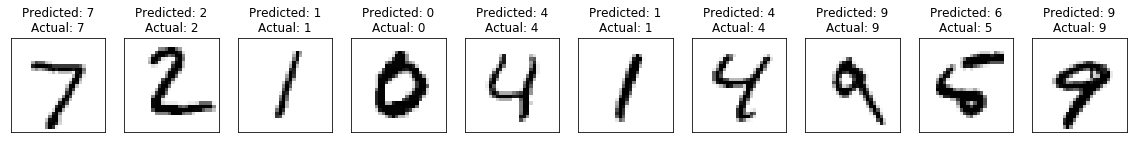

In [10]:
# This returns a generator object
predictions = estimator.predict(input_fn=test_input)

# how many digits we will display
n = 10

i = 0
plt.figure(figsize=(20, 4))
for p in predictions:
    # display original
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(images_test[i].reshape(28, 28), cmap=plt.cm.gray_r)
    actual = labels_test[i]
    predicted = p['class_ids'][0]
    ax.set_title("Predicted: %d\nActual: %d" % (predicted, actual))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
    if i == n:
        break

# Deep neural network

``tf.estimator`` offers a variety of predefined models. Here, we'll configure a *Deep Neural Network Classifier* model using the provided [DNNClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) class. We supply all the configuration parameters right in the constructor, e.g.:

In [12]:
estimator = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[256, 256], # we will arbitrarily use two hidden layer
    n_classes=10,
    model_dir="./graphs/04_canned/deep")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './graphs/04_canned/deep', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


See how easy it is to switch the model to a fully connected DNN.

In [13]:
# I've arbitrarily decided to train for 2000 steps
estimator.train(train_input, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./graphs/04_canned/deep/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into ./graphs/04_canned/deep/model.ckpt.
INFO:tensorflow:loss = 0.988206, step = 4001
INFO:tensorflow:global_step/sec: 151.737
INFO:tensorflow:loss = 0.55815, step = 4101 (0.660 sec)
INFO:tensorflow:global_step/sec: 156.458
INFO:tensorflow:loss = 2.24853, step = 4201 (0.640 sec)
INFO:tensorflow:global_step/sec: 154.656
INFO:tensorflow:loss = 0.795035, step = 4301 (0.646 sec)
INFO:tensorflow:global_step/sec: 149.701
INFO:tensorflow:loss = 2.56438, step = 4401 (0.668 sec)
INFO:tensorflow:global_step/sec: 152.221
INFO:tensorflow:loss = 1.87555, step = 4501 (0.659 sec)
INFO:tensorflow:global_step/sec: 147.595
INFO:tensorflow:loss = 2.76659, step = 4601 (0.675 sec)
INFO:tensorflow:global_step/sec: 155.876
INFO:tensorflow:loss = 0.963839, step = 4701 (0.642 sec)
INFO:tensorflow:global_step/sec: 155.463
INFO:tensorflow:loss =

In [14]:
# Expect accuracy around 97%
evaluation = estimator.evaluate(input_fn=test_input)
print(evaluation)

INFO:tensorflow:Starting evaluation at 2017-10-03-21:15:48
INFO:tensorflow:Restoring parameters from ./graphs/04_canned/deep/model.ckpt-6000
INFO:tensorflow:Finished evaluation at 2017-10-03-21:15:49
INFO:tensorflow:Saving dict for global step 6000: accuracy = 0.9764, average_loss = 0.0935217, global_step = 6000, loss = 11.8382
{'accuracy': 0.97640002, 'average_loss': 0.09352167, 'loss': 11.838185, 'global_step': 6000}


## TensorBoard

If you like, you can start TensorBoard by running this from a terminal command (in the same directory as this notebook):

``` $ tensorboard --logdir=./graphs/04_canned/ ```

then pointing your web-browser to http://localhost:6006 (check the TensorBoard output in the terminal in case it's running on a different port).

When that launches, you'll be able to see a variety of graphs that compares the linear and deep models.

# More models

Although the Estimators we used here are relative simple (a LinearClassifier, and a Fully Connected Deep Neural Network), TensorFlow also provides more interesting ones (e.g. a [Wide and Deep model](https://www.tensorflow.org/tutorials/wide_and_deep).

To learn more about Estimators, you can watch this talk from Google I/O by Martin Wicke: [Effective TensorFlow for Non-Experts](https://www.youtube.com/watch?v=5DknTFbcGVM).